In [37]:
!git clone https://github.com/boupojp/issueDT20-21.git

fatal: destination path 'issueDT20-21' already exists and is not an empty directory.


# **Test** **parameters**

In [38]:
oldversion = 1 # oldversion = 1 to select deeptrack 2.0, oldversion = 0 to select deeptrack 2.1
UPSCALE = 7; # upscale value for dt.Brightfield 

In [39]:
import sys
import os
sys.path.insert(0,"/content/issueDT20-21/")

In [40]:
# environment setup

if int(os.environ["COLAB_GPU"]) > 0: # if you use a GPU runtime type, this enables the GPU use 
  !curl https://colab.chainer.org/install | sh -

  !pip install cucim
  !pip install scipy scikit-image cupy-cuda100

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   8777      0 --:--:-- --:--:-- --:--:--  8777
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
# import packages

import numpy as np
import matplotlib.pyplot as plt

In [42]:
# select the version of deeptrack

if oldversion:

  import olddeeptrack as dt

else:

    !pip install deeptrack
    import deeptrack as dt

In [43]:
# function to generate images for new version (DeepTrack 2.1)
if not oldversion:

    print("NEW VERSION")

    def generate_simulated_image(
        image_size=(64, 64),
        pix_size=5.2,
        z_pix_size = 0.1,#5.2,
        radius=(7.06/2) * 1e-6,
        ri=1.59,
        z=2541,
        apod_val=0.3, # Now it is between 0 and 1 (optimal is somewhere between 0.3 and 0.5)
        sigma = 0.025,
        add_noise=False,
    ):
        """
    Generates a simulated image with the given parameters.

    Parameters
    ----------
    image_size : tuple
        The size of the image to be generated.
    pix_size : float
        The size of the pixels in the image.
    radius : float
        The radius of the sphere.
    ri : float
        The refractive index of the sphere.
    z : float
        The distance of the sphere from the camera.
    apod_val : float
        The apodization value of the sphere.
    Returns
    -------
    image : ndarray
        The simulated image.
        """

        sphere_main = dt.Sphere(
        position=(32, 32),
        position_unit="pixel",
        cam_pix_size=pix_size,
        radius=radius,
        refractive_index=ri,
        z=z / z_pix_size,
        )

        optics = dt.Brightfield(
            wavelength=633e-9,
            NA=1,
            resolution=[pix_size * 1e-6, pix_size * 1e-6, z_pix_size * 1e-6],
            magnification=1,
            refractive_index_medium=1.33,
            upscale=UPSCALE,
            padding = 10*[1,1,1,1],
            pupil = dt.GaussianApodization(sigma=apod_val),
            output_region=(0, 0, image_size[0], image_size[1]),
        )

        noise = dt.Gaussian(mu=0, sigma=sigma)

        sphere_main_no = lambda: np.random.randint(1, 2)

        sample_normal = sphere_main ^ sphere_main_no
        
        if add_noise:
        
            image_formed = optics(sample_normal) >> noise

        else:

            image_formed = optics(sample_normal)

        image = image_formed.update().resolve()

        return np.array(image[:,:,0])

In [44]:
# function to generate images for old version (DeepTrack 2.0)
if oldversion:

    print("OLD VERSION")

    from olddeeptrack.noises import Noise
    
    class Blurred_Gaussian(Noise):
        """Adds IID Gaussian noise to an image
        Parameters
        ----------
        mu : float
        The mean of the distribution.
        sigma : float
        The root of the variance of the distribution.
        """

        np.random.seed(0) # To make the noise predictable

        def __init__(self, mu=0, sigma=1, blur=2, **kwargs):
            super().__init__(mu=mu, sigma=sigma, blur=blur, **kwargs)

        def get(self, image, mu, sigma, blur, **kwargs):

            noisy_image = mu + np.random.randn(*image.shape) * sigma
            noisy_image = gaussian(noisy_image, sigma=blur)
            noisy_image = image + noisy_image
            return noisy_image

    def generate_simulated_image(
        image_size=(64, 64), # px
        pix_size=5.2, #3.6, #um/px
        z_pix_size = 1, #3.6, # um/px
        radius=(7.06/2) * 1e-6, # (6.59/2) * 1e-6,
        ri=1.59, # refractive index
        z=2541, # um
        apod_val=0.07,
        sigma = 0.025,
        blur=0.8,
        add_noise=True,
        ):
        """
        Generates a simulated image with the given parameters   .

        Parameters
        ----------
        image_size : tuple
        The size of the image to be generated.
        pix_size : float
        The size of the pixels in the image.
        radius : float
        The radius of the sphere.
        ri : float
        The refractive index of the sphere.
        z : float
        The distance of the sphere from the camera.
        apod_val : float
        The apodization value of the sphere.
        blur : float
        The blur value of the image.

        Returns
        -------
        image : ndarray
        The simulated image.
        """

        sphere_main = dt.Sphere(
            position=(32, 32),
            position_unit="pixel",
            cam_pix_size=pix_size,
            radius=radius,
            refractive_index=ri,
            z=z / z_pix_size,
            find_me=True,
        )

        optics = dt.Brightfield(
            wavelength=633e-9,
            NA=1,
            resolution=[pix_size * 1e-6, pix_size * 1e-6, z_pix_size * 1e-6],
            magnification=1,
            refractive_index_medium=1.33,
            apod_val=apod_val,
            upscale=UPSCALE, # if 1 images changes changing z_pix_size, if 2 images still change but are more similar, with 4 fixed
            aberration=lambda apod_val: dt.GaussianApodization(apod_val),
            output_region=(0, 0, image_size[0], image_size[1]),
        )

        noise = Blurred_Gaussian(
            mu=0, sigma=sigma, blur=blur
        )

        sphere_main_no = lambda: np.random.randint(1, 2)

        sample_normal = sphere_main ** sphere_main_no

        if add_noise:
            image_formed = optics(sample_normal) + noise
        else:
            image_formed = optics(sample_normal)

        image = image_formed.update().resolve()
        
        return image[:,:,0]

OLD VERSION


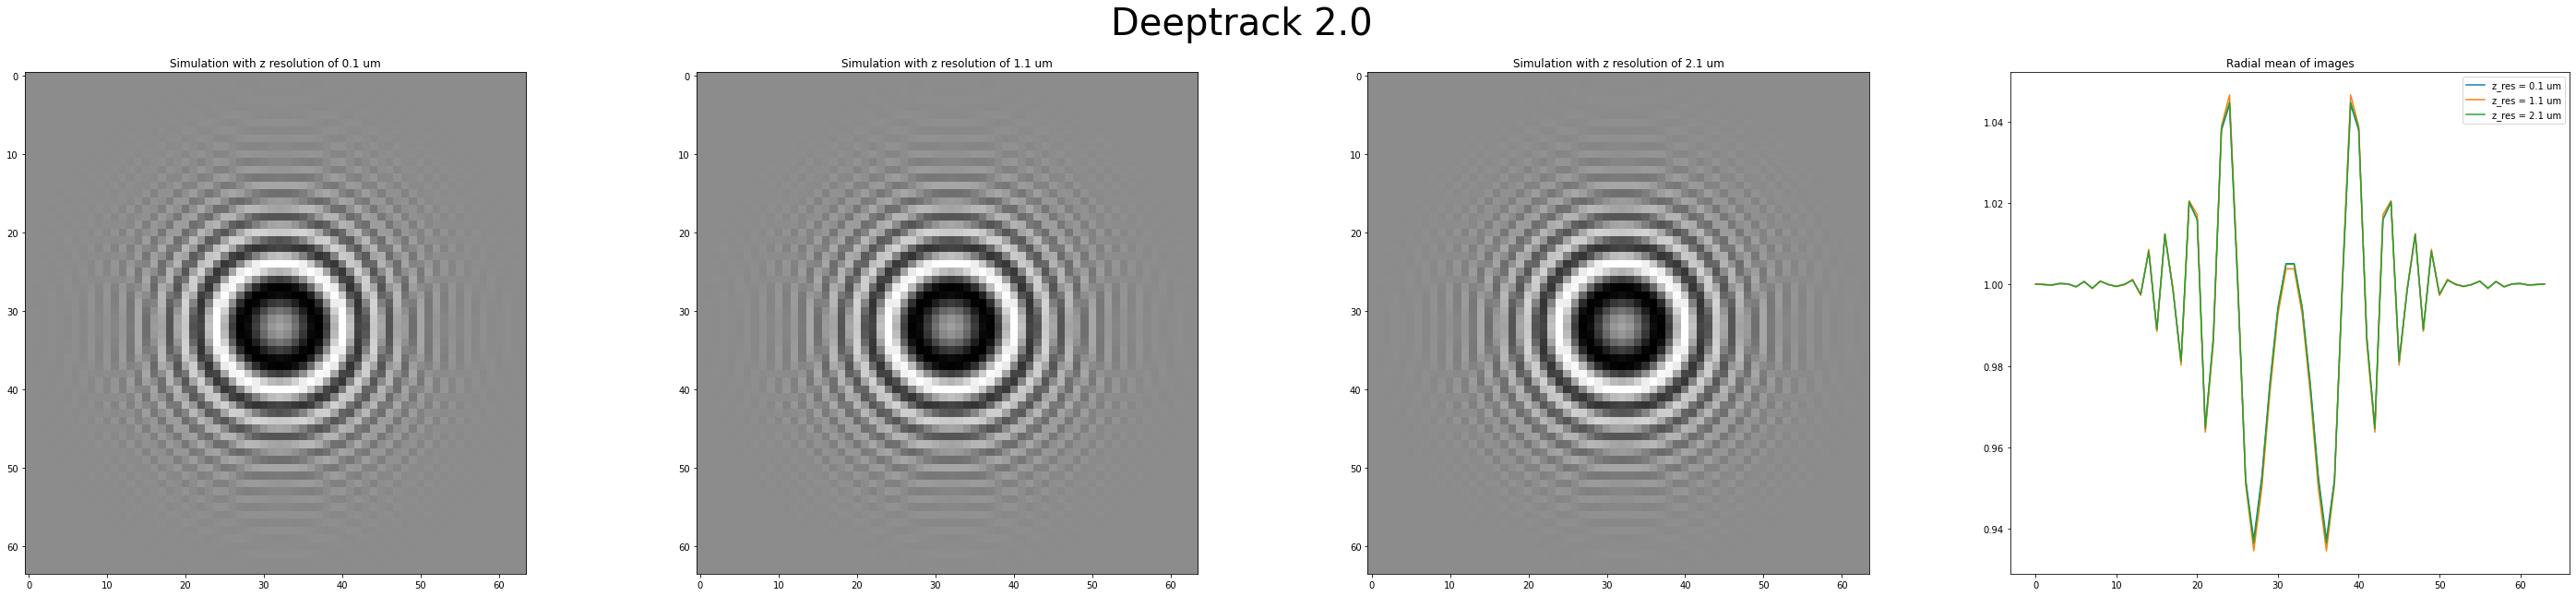

In [45]:
# function to do radial mean
def radial_mean(im):

  x,y = np.meshgrid(np.arange(im.shape[1]),np.arange(im.shape[0]))
  x0,y0 = im.shape[1]/2,im.shape[0]/2
  
  R = np.sqrt((x-x0)**2+(y-y0)**2)
  r0 = np.sqrt(x0**2+y0**2)

  f = lambda r : im[(R >= r-0.5) & (R < r+0.5)].mean()
  r  = np.abs(np.linspace(-im.shape[0]/2,im.shape[0]/2,num=im.shape[0]))

  im_mean = np.vectorize(f)(r)

  return im_mean

# Images generation

zPos = 2445 

if oldversion:

  apo = 0.08

else:

  apo = 0.332

image2 = generate_simulated_image(apod_val=apo, sigma = 0.0015, z = zPos, add_noise=False,z_pix_size = 2.1)
image1 = generate_simulated_image(apod_val=apo, sigma = 0.0015, z = zPos, add_noise=False,z_pix_size = 1.1)
image0 = generate_simulated_image(apod_val=apo, sigma = 0.0015, z = zPos, add_noise=False,z_pix_size = 0.1)

plt.figure(figsize=(50, 10))
if oldversion:
  plt.suptitle('Deeptrack 2.0',fontsize=40)
else:
  plt.suptitle('Deeptrack 2.1',fontsize=40)

plt.subplot(1,4,1)
plt.title("Simulation with z resolution of 0.1 um")
plt.imshow(image0, cmap="gray")
plt.subplot(1,4,2)
plt.title("Simulation with z resolution of 1.1 um")
plt.imshow(image1, cmap="gray")
plt.subplot(1,4,3)
plt.title("Simulation with z resolution of 2.1 um")
plt.imshow(image2, cmap="gray")
plt.subplot(1,4,4)
plt.title("Radial mean of images")
plt.plot(radial_mean(image0), label="z_res = 0.1 um")
plt.plot(radial_mean(image1), label="z_res = 1.1 um")
plt.plot(radial_mean(image2), label="z_res = 2.1 um")
plt.legend()